## STEP 1: Import Libraries

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# SMOTE (Jurnal Sahfa et al.)
from imblearn.over_sampling import SMOTE

# Filter Methods
from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest, 
    chi2,                      # Sahfa et al.
    mutual_info_classif,       # Sahfa et al.
    f_classif                  # Literature umum (ANOVA F-test)
)

# Wrapper Methods
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Embedded Methods
from sklearn.linear_model import LassoCV
import xgboost as xgb
import lightgbm as lgb

print("Libraries loaded successfully")

Libraries loaded successfully


## STEP 2: Load and Prepare Datasets

In [2]:
# Load datasets
swat_df = pd.read_csv('SWAT_Dataset.csv').sample(1000, random_state=42)
print(f"SWAT: {swat_df.shape[0]} samples × {swat_df.shape[1]} features")

wadi_df = pd.read_csv('WADI.csv').sample(500, random_state=42)
print(f"WADI: {wadi_df.shape[0]} samples × {wadi_df.shape[1]} features")

# Remove non-numeric columns from WADI
non_numeric_cols = wadi_df.select_dtypes(include=['object']).columns.tolist()
cols_to_drop = [col for col in non_numeric_cols if col not in ['Normal/Attack', 'Attack']]
if cols_to_drop:
    print(f"Removing: {cols_to_drop}")
    wadi_df = wadi_df.drop(columns=cols_to_drop)

# Standardize target column
if 'Attack' in wadi_df.columns and 'Normal/Attack' not in wadi_df.columns:
    wadi_df['Normal/Attack'] = wadi_df['Attack'].apply(lambda x: 'Attack' if x == 1 else 'Normal')
    wadi_df = wadi_df.drop(columns=['Attack'])

datasets = {'SWAT': swat_df, 'WADI': wadi_df}

# Dataset statistics
print("\n" + "="*60)
for name, df in datasets.items():
    target_col = 'Normal/Attack'
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Distribution:\n{df[target_col].value_counts()}")
    attack_ratio = (df[target_col] == 'Attack').sum() / len(df)
    print(f"  Attack ratio: {attack_ratio:.3f} ({'Imbalanced' if attack_ratio < 0.3 else 'Balanced'})")

SWAT: 1000 samples × 53 features
WADI: 500 samples × 126 features
Removing: ['Date', 'Time']


SWAT:
  Shape: (1000, 53)
  Distribution:
Normal/Attack
Normal    850
Attack    150
Name: count, dtype: int64
  Attack ratio: 0.150 (Imbalanced)

WADI:
  Shape: (500, 124)
  Distribution:
Normal/Attack
Normal    450
Attack     50
Name: count, dtype: int64
  Attack ratio: 0.100 (Imbalanced)


## STEP 3: Feature Selection Pipeline
**Metodologi**: Ensemble approach combining 9 methods from literature

In [3]:
def feature_selection_pipeline(df, dataset_name, target_col='Normal/Attack', 
                               apply_smote=True, k_features=30):
    """
    Ensemble feature selection: Filter + Wrapper + Embedded methods
    Based on Sahfa et al. (2024) methodology
    """
    
    print(f"\n{'='*60}")
    print(f"FEATURE SELECTION: {dataset_name}")
    print(f"{'='*60}")
    
    # Prepare data
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    feature_names = X.columns.tolist()
    n_original = len(feature_names)
    
    print(f"\nOriginal: {n_original} features")
    print(f"Classes: {dict(Counter(y))}")
    
    # STAGE 1: Variance Filter
    print(f"\n[1/6] Variance Filtering")
    variance_selector = VarianceThreshold(threshold=0.01)
    X_var = pd.DataFrame(
        variance_selector.fit_transform(X),
        columns=X.columns[variance_selector.get_support()]
    )
    removed = n_original - X_var.shape[1]
    print(f"  Removed: {removed}, Remaining: {X_var.shape[1]}")
    
    feature_names = X_var.columns.tolist()
    X = X_var
    
    # STAGE 2: SMOTE Balancing (Jurnal Sahfa et al.)
    if apply_smote:
        print(f"\n[2/6] SMOTE Balancing (Sahfa et al.)")
        class_counts = Counter(y_encoded)
        print(f"  Before: {dict(zip(le.classes_, [class_counts[i] for i in range(len(le.classes_))]))}")
        
        smote = SMOTE(random_state=42)
        X_balanced, y_balanced = smote.fit_resample(X, y_encoded)
        
        class_counts_after = Counter(y_balanced)
        print(f"  After: {dict(zip(le.classes_, [class_counts_after[i] for i in range(len(le.classes_))]))}")
    else:
        X_balanced = X.values
        y_balanced = y_encoded
        print(f"\n[2/6] SMOTE Skipped")
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_balanced)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )
    
    selected_features = {}
    
    print(f"\n[3/6] Filter Methods")
    
    # Method 1: Chi-Square (Sahfa et al.)
    X_nonneg = X_balanced - X_balanced.min()
    chi2_selector = SelectKBest(chi2, k=min(k_features, len(feature_names)))
    chi2_selector.fit(X_nonneg, y_balanced)
    chi2_features = [feature_names[i] for i in chi2_selector.get_support(indices=True)]
    selected_features['Chi-Square'] = chi2_features
    print(f"  Chi-Square: {len(chi2_features)} features")
    
    # Method 2: Mutual Information (Sahfa et al.)
    mi_selector = SelectKBest(mutual_info_classif, k=min(k_features, len(feature_names)))
    mi_selector.fit(X_scaled, y_balanced)
    mi_features = [feature_names[i] for i in mi_selector.get_support(indices=True)]
    selected_features['Mutual_Information'] = mi_features
    print(f"  Mutual Info: {len(mi_features)} features")
    
    # Method 3: ANOVA F-test (Literature umum)
    anova_selector = SelectKBest(f_classif, k=min(k_features, len(feature_names)))
    anova_selector.fit(X_scaled, y_balanced)
    anova_features = [feature_names[i] for i in anova_selector.get_support(indices=True)]
    selected_features['ANOVA'] = anova_features
    print(f"  ANOVA: {len(anova_features)} features")
    
    # Method 4: Pearson Correlation (Sreehari & Dhinesh)
    df_corr = pd.DataFrame(X_scaled, columns=feature_names)
    df_corr['target'] = y_balanced
    correlations = df_corr.corr()['target'].abs().drop('target')
    corr_features = correlations.nlargest(min(k_features, len(feature_names))).index.tolist()
    selected_features['Correlation'] = corr_features
    print(f"  Correlation: {len(corr_features)} features")
    
    print(f"\n[4/6] Wrapper Method")
    
    # Method 5: RFE (Sahfa et al.)
    rf_rfe = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rfe = RFE(rf_rfe, n_features_to_select=min(k_features, len(feature_names)))
    rfe.fit(X_train, y_train)
    rfe_features = [feature_names[i] for i in range(len(feature_names)) if rfe.support_[i]]
    selected_features['RFE_RandomForest'] = rfe_features
    print(f"  RFE: {len(rfe_features)} features")
    
    print(f"\n[5/6] Embedded Methods")
    
    # Method 6: Random Forest (Sahfa et al.)
    rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    importances = pd.Series(rf.feature_importances_, index=feature_names)
    rf_features = importances.nlargest(min(k_features, len(feature_names))).index.tolist()
    selected_features['RandomForest'] = rf_features
    print(f"  Random Forest: {len(rf_features)} features")
    
    # Method 7: XGBoost (Sahfa et al.)
    xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
    xgb_model.fit(X_train, y_train)
    xgb_importances = pd.Series(xgb_model.feature_importances_, index=feature_names)
    xgb_features = xgb_importances.nlargest(min(k_features, len(feature_names))).index.tolist()
    selected_features['XGBoost'] = xgb_features
    print(f"  XGBoost: {len(xgb_features)} features")
    
    # Method 8: LightGBM (Enhancement)
    lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
    lgb_model.fit(X_train, y_train)
    lgb_importances = pd.Series(lgb_model.feature_importances_, index=feature_names)
    lgb_features = lgb_importances.nlargest(min(k_features, len(feature_names))).index.tolist()
    selected_features['LightGBM'] = lgb_features
    print(f"  LightGBM: {len(lgb_features)} features")
    
    # Method 9: LASSO (Sahfa et al.)
    lasso = LassoCV(cv=5, random_state=42, max_iter=1000)
    lasso.fit(X_train, y_train)
    lasso_coefs = pd.Series(np.abs(lasso.coef_), index=feature_names)
    lasso_features = lasso_coefs.nlargest(min(k_features, len(feature_names))).index.tolist()
    selected_features['LASSO'] = lasso_features
    print(f"  LASSO: {len(lasso_features)} features")
    
    # STAGE 6: Ensemble Voting
    print(f"\n[6/6] Ensemble Voting")
    vote_counter = Counter()
    for method, features in selected_features.items():
        for feature in features:
            vote_counter[feature] += 1
    
    voting_df = pd.DataFrame([
        {'Feature': feat, 'Votes': votes, 'Vote_Ratio': votes/len(selected_features)}
        for feat, votes in vote_counter.items()
    ]).sort_values('Votes', ascending=False)
    
    # Add method details
    for method, features in selected_features.items():
        voting_df[method] = voting_df['Feature'].apply(lambda x: '✓' if x in features else '')
    
    print(f"  Unique features: {len(voting_df)}")
    print(f"  Vote distribution:")
    for v in range(len(selected_features), 0, -1):
        count = (voting_df['Votes'] == v).sum()
        if count > 0:
            print(f"    {v} votes: {count} features")
    
    # Threshold results
    thresholds = [4, 5, 6, 7, 9]
    threshold_results = {}
    for t in thresholds:
        if t <= len(selected_features):
            selected = voting_df[voting_df['Votes'] >= t]['Feature'].tolist()
            threshold_results[f"threshold_{t}"] = selected
    
    print(f"\n{'='*60}")
    print(f"COMPLETED: {dataset_name}")
    print(f"{'='*60}")
    
    return {
        'voting_df': voting_df,
        'selected_features': selected_features,
        'threshold_results': threshold_results,
        'num_methods': len(selected_features),
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'feature_names': feature_names,
        'label_encoder': le,
        'scaler': scaler,
        'reduction_log': {
            'original': n_original,
            'after_variance': n_original - removed,
            'unique_in_pool': len(voting_df)
        }
    }

print("Pipeline defined")

Pipeline defined


## STEP 4: Execute Pipeline on Both Datasets

In [4]:
# Execute pipeline for both datasets
results = {}

for dataset_name in ['SWAT', 'WADI']:
    df = datasets[dataset_name]
    
    # Check if SMOTE needed
    attack_ratio = (df['Normal/Attack'] == 'Attack').sum() / len(df)
    apply_smote = attack_ratio < 0.3
    
    results[dataset_name] = feature_selection_pipeline(
        df=df,
        dataset_name=dataset_name,
        target_col='Normal/Attack',
        apply_smote=apply_smote,
        k_features=30
    )

print("\n" + "="*60)
print("BOTH DATASETS PROCESSED")
print("="*60)


FEATURE SELECTION: SWAT

Original: 52 features
Classes: {'Normal': 850, 'Attack': 150}

[1/6] Variance Filtering
  Removed: 0, Remaining: 52

[2/6] SMOTE Balancing (Sahfa et al.)
  Before: {'Attack': 150, 'Normal': 850}
  After: {'Attack': 850, 'Normal': 850}

[3/6] Filter Methods
  Chi-Square: 30 features
  After: {'Attack': 850, 'Normal': 850}

[3/6] Filter Methods
  Chi-Square: 30 features
  Mutual Info: 30 features
  ANOVA: 30 features
  Correlation: 30 features

[4/6] Wrapper Method
  Mutual Info: 30 features
  ANOVA: 30 features
  Correlation: 30 features

[4/6] Wrapper Method
  RFE: 30 features

[5/6] Embedded Methods
  RFE: 30 features

[5/6] Embedded Methods
  Random Forest: 30 features
  Random Forest: 30 features
  XGBoost: 30 features
  LightGBM: 30 features
  XGBoost: 30 features
  LightGBM: 30 features
  LASSO: 30 features

[6/6] Ensemble Voting
  Unique features: 49
  Vote distribution:
    9 votes: 8 features
    8 votes: 7 features
    7 votes: 4 features
    6 votes:

## STEP 5: Cross-Dataset Analysis

In [5]:
print("\n" + "="*60)
print("CROSS-DATASET VALIDATION")
print("="*60)

threshold = 5

swat_features_t5 = set(results['SWAT']['threshold_results'][f'threshold_{threshold}'])
wadi_features_t5 = set(results['WADI']['threshold_results'][f'threshold_{threshold}'])

print(f"\nFeatures at threshold ≥{threshold}:")
print(f"  SWAT: {len(swat_features_t5)} features")
print(f"  WADI: {len(wadi_features_t5)} features")

common_features = swat_features_t5.intersection(wadi_features_t5)
print(f"\nCommon features: {len(common_features)}")
if len(common_features) > 0:
    print(f"  Features: {sorted(common_features)}")
else:
    print(f"  Note: Different sensor configurations expected")

swat_only = swat_features_t5 - wadi_features_t5
wadi_only = wadi_features_t5 - swat_features_t5

print(f"\nSWAT-specific: {len(swat_only)}")
print(f"WADI-specific: {len(wadi_only)}")

cross_validation = {
    'common_features': list(common_features),
    'swat_only': list(swat_only),
    'wadi_only': list(wadi_only),
    'threshold': threshold
}


CROSS-DATASET VALIDATION

Features at threshold ≥5:
  SWAT: 31 features
  WADI: 17 features

Common features: 0
  Note: Different sensor configurations expected

SWAT-specific: 31
WADI-specific: 17


## STEP 6: Save Results

In [6]:
print("\n" + "="*60)
print("SAVING RESULTS")
print("="*60)

# Save voting results
for dataset_name in ['SWAT', 'WADI']:
    voting_df = results[dataset_name]['voting_df']
    filename = f'v3_{dataset_name.lower()}_feature_voting.csv'
    voting_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

# Save threshold selections
for dataset_name in ['SWAT', 'WADI']:
    threshold_results = results[dataset_name]['threshold_results']
    for thresh_name, features in threshold_results.items():
        filename = f'v3_{dataset_name.lower()}_{thresh_name}.csv'
        pd.DataFrame({'Feature': features}).to_csv(filename, index=False)
        print(f"Saved: {filename}")

# Save cross-validation
pd.DataFrame({
    'Common_Features': pd.Series(cross_validation['common_features']),
    'SWAT_Only': pd.Series(cross_validation['swat_only']),
    'WADI_Only': pd.Series(cross_validation['wadi_only'])
}).to_csv('v3_cross_dataset_validation.csv', index=False)
print(f"Saved: v3_cross_dataset_validation.csv")

# Save reduction tracking
reduction_data = []
for dataset_name in ['SWAT', 'WADI']:
    log = results[dataset_name]['reduction_log']
    reduction_data.append({
        'Dataset': dataset_name,
        'Original_Features': log['original'],
        'After_Variance_Filter': log['after_variance'],
        'Unique_in_Voting_Pool': log['unique_in_pool'],
        'Selected_at_Threshold_5': len(results[dataset_name]['threshold_results']['threshold_5'])
    })

pd.DataFrame(reduction_data).to_csv('v3_feature_reduction_tracking.csv', index=False)
print(f"Saved: v3_feature_reduction_tracking.csv")

print("\n" + "="*60)
print("ALL RESULTS SAVED")
print("="*60)


SAVING RESULTS
Saved: v3_swat_feature_voting.csv
Saved: v3_wadi_feature_voting.csv
Saved: v3_swat_threshold_4.csv
Saved: v3_swat_threshold_5.csv
Saved: v3_swat_threshold_6.csv
Saved: v3_swat_threshold_7.csv
Saved: v3_swat_threshold_9.csv
Saved: v3_wadi_threshold_4.csv
Saved: v3_wadi_threshold_5.csv
Saved: v3_wadi_threshold_6.csv
Saved: v3_wadi_threshold_7.csv
Saved: v3_wadi_threshold_9.csv
Saved: v3_cross_dataset_validation.csv
Saved: v3_feature_reduction_tracking.csv

ALL RESULTS SAVED


## STEP 7: Visualization


✓ Visualization saved: v3_feature_selection_results.png


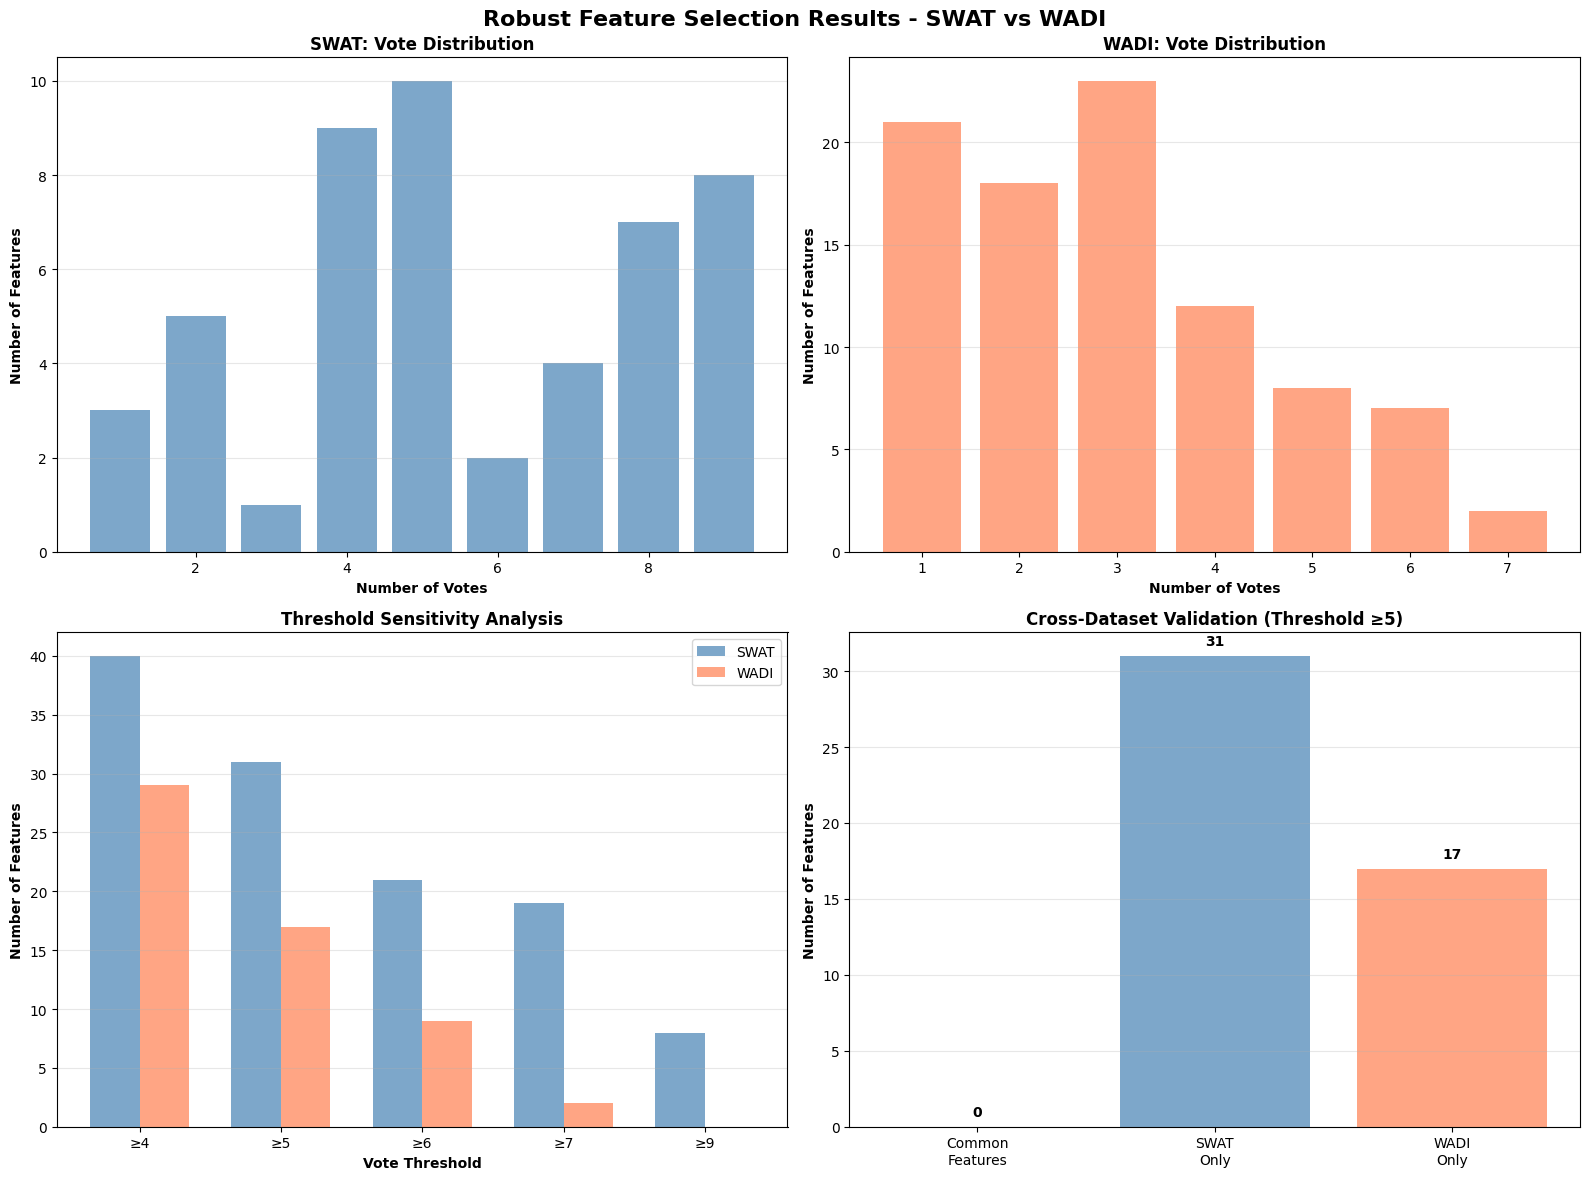

In [7]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Robust Feature Selection Results - SWAT vs WADI', fontsize=16, fontweight='bold')

# Plot 1: Vote distribution for SWAT
swat_votes = results['SWAT']['voting_df']['Votes'].value_counts().sort_index(ascending=False)
axes[0, 0].bar(swat_votes.index, swat_votes.values, color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Number of Votes', fontweight='bold')
axes[0, 0].set_ylabel('Number of Features', fontweight='bold')
axes[0, 0].set_title('SWAT: Vote Distribution', fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Vote distribution for WADI
wadi_votes = results['WADI']['voting_df']['Votes'].value_counts().sort_index(ascending=False)
axes[0, 1].bar(wadi_votes.index, wadi_votes.values, color='coral', alpha=0.7)
axes[0, 1].set_xlabel('Number of Votes', fontweight='bold')
axes[0, 1].set_ylabel('Number of Features', fontweight='bold')
axes[0, 1].set_title('WADI: Vote Distribution', fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Threshold sensitivity
thresholds = [4, 5, 6, 7, 9]
swat_counts = [len(results['SWAT']['threshold_results'].get(f'threshold_{t}', [])) 
               for t in thresholds]
wadi_counts = [len(results['WADI']['threshold_results'].get(f'threshold_{t}', [])) 
               for t in thresholds]

x = np.arange(len(thresholds))
width = 0.35
axes[1, 0].bar(x - width/2, swat_counts, width, label='SWAT', color='steelblue', alpha=0.7)
axes[1, 0].bar(x + width/2, wadi_counts, width, label='WADI', color='coral', alpha=0.7)
axes[1, 0].set_xlabel('Vote Threshold', fontweight='bold')
axes[1, 0].set_ylabel('Number of Features', fontweight='bold')
axes[1, 0].set_title('Threshold Sensitivity Analysis', fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f'≥{t}' for t in thresholds])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Cross-dataset comparison
comparison_data = {
    'Common\nFeatures': len(cross_validation['common_features']),
    'SWAT\nOnly': len(cross_validation['swat_only']),
    'WADI\nOnly': len(cross_validation['wadi_only'])
}
colors = ['green', 'steelblue', 'coral']
axes[1, 1].bar(comparison_data.keys(), comparison_data.values(), color=colors, alpha=0.7)
axes[1, 1].set_ylabel('Number of Features', fontweight='bold')
axes[1, 1].set_title(f'Cross-Dataset Validation (Threshold ≥{threshold})', fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (k, v) in enumerate(comparison_data.items()):
    axes[1, 1].text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('v3_feature_selection_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved: v3_feature_selection_results.png")
plt.show()

## STEP 8: Summary Report

In [8]:
print("\n" + "="*60)
print("SUMMARY REPORT")
print("="*60)

print("\nMETHODOLOGY:")
print("  9 Feature Selection Methods:")
print("    - Filter: Chi-Square, MI, ANOVA, Correlation")
print("    - Wrapper: RFE")
print("    - Embedded: RF, XGBoost, LightGBM, LASSO")
print("  SMOTE balancing (Sahfa et al.)")
print("  Ensemble voting")

print("\nSWAT RESULTS:")
swat_log = results['SWAT']['reduction_log']
print(f"  Original: {swat_log['original']}")
print(f"  After variance filter: {swat_log['after_variance']}")
print(f"  Unique in pool: {swat_log['unique_in_pool']}")
print(f"  Selected (≥5 votes): {len(results['SWAT']['threshold_results']['threshold_5'])}")
print(f"  Perfect consensus (9/9): {(results['SWAT']['voting_df']['Votes'] == 9).sum()}")

print("\nWADI RESULTS:")
wadi_log = results['WADI']['reduction_log']
print(f"  Original: {wadi_log['original']}")
print(f"  After variance filter: {wadi_log['after_variance']}")
print(f"  Unique in pool: {wadi_log['unique_in_pool']}")
print(f"  Selected (≥5 votes): {len(results['WADI']['threshold_results']['threshold_5'])}")
print(f"  Perfect consensus (9/9): {(results['WADI']['voting_df']['Votes'] == 9).sum()}")

print("\nCROSS-DATASET:")
print(f"  Common features: {len(cross_validation['common_features'])}")
print(f"  SWAT-specific: {len(cross_validation['swat_only'])}")
print(f"  WADI-specific: {len(cross_validation['wadi_only'])}")

print("\nOUTPUT FILES:")
print("  v3_swat_feature_voting.csv")
print("  v3_wadi_feature_voting.csv")
print("  v3_*_threshold_*.csv (multiple thresholds)")
print("  v3_cross_dataset_validation.csv")
print("  v3_feature_reduction_tracking.csv")
print("  v3_feature_selection_results.png")

print("\n" + "="*60)
print("FEATURE SELECTION COMPLETE")
print("="*60)


SUMMARY REPORT

METHODOLOGY:
  9 Feature Selection Methods:
    - Filter: Chi-Square, MI, ANOVA, Correlation
    - Wrapper: RFE
    - Embedded: RF, XGBoost, LightGBM, LASSO
  SMOTE balancing (Sahfa et al.)
  Ensemble voting

SWAT RESULTS:
  Original: 52
  After variance filter: 52
  Unique in pool: 49
  Selected (≥5 votes): 31
  Perfect consensus (9/9): 8

WADI RESULTS:
  Original: 123
  After variance filter: 123
  Unique in pool: 91
  Selected (≥5 votes): 17
  Perfect consensus (9/9): 0

CROSS-DATASET:
  Common features: 0
  SWAT-specific: 31
  WADI-specific: 17

OUTPUT FILES:
  v3_swat_feature_voting.csv
  v3_wadi_feature_voting.csv
  v3_*_threshold_*.csv (multiple thresholds)
  v3_cross_dataset_validation.csv
  v3_feature_reduction_tracking.csv
  v3_feature_selection_results.png

FEATURE SELECTION COMPLETE


## STEP 9: Model Validation
Compare performance: ALL features vs SELECTED features

In [9]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import time

def evaluate_model_performance(dataset_name, results_dict, original_df, target_col='Normal/Attack'):
    """Compare ALL features vs SELECTED features"""
    
    print(f"\n{'='*60}")
    print(f"MODEL VALIDATION: {dataset_name}")
    print(f"{'='*60}")
    
    X_all = original_df.drop(columns=[target_col])
    y = original_df[target_col]
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    selected_features = results_dict['threshold_results']['threshold_5']
    X_selected = X_all[selected_features]
    
    print(f"\nDataset:")
    print(f"  Samples: {len(X_all)}")
    print(f"  All features: {X_all.shape[1]}")
    print(f"  Selected: {X_selected.shape[1]}")
    print(f"  Reduction: {100*(1 - X_selected.shape[1]/X_all.shape[1]):.1f}%")
    
    X_all_train, X_all_test, y_train, y_test = train_test_split(
        X_all, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
    )
    X_sel_train, X_sel_test = train_test_split(
        X_selected, test_size=0.3, random_state=42, stratify=y_encoded
    )[0:2]
    
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss'),
        'LightGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
    }
    
    performance_results = []
    
    for model_name, model in models.items():
        print(f"\n{model_name}:")
        
        # ALL features
        start = time.time()
        model_all = model.__class__(**model.get_params())
        model_all.fit(X_all_train, y_train)
        time_all = time.time() - start
        
        y_pred_all = model_all.predict(X_all_test)
        y_proba_all = model_all.predict_proba(X_all_test)[:, 1]
        
        acc_all = accuracy_score(y_test, y_pred_all)
        f1_all = f1_score(y_test, y_pred_all, average='binary')
        auc_all = roc_auc_score(y_test, y_proba_all)
        
        # SELECTED features
        start = time.time()
        model_sel = model.__class__(**model.get_params())
        model_sel.fit(X_sel_train, y_train)
        time_sel = time.time() - start
        
        y_pred_sel = model_sel.predict(X_sel_test)
        y_proba_sel = model_sel.predict_proba(X_sel_test)[:, 1]
        
        acc_sel = accuracy_score(y_test, y_pred_sel)
        f1_sel = f1_score(y_test, y_pred_sel, average='binary')
        auc_sel = roc_auc_score(y_test, y_proba_sel)
        
        speedup = time_all / time_sel
        
        print(f"  ALL ({X_all.shape[1]} features):")
        print(f"    F1: {f1_all:.4f}, Acc: {acc_all:.4f}, Time: {time_all:.2f}s")
        print(f"  SELECTED ({X_selected.shape[1]} features):")
        print(f"    F1: {f1_sel:.4f} ({f1_sel-f1_all:+.4f})")
        print(f"    Acc: {acc_sel:.4f} ({acc_sel-acc_all:+.4f})")
        print(f"    Speedup: {speedup:.2f}x")
        
        performance_results.append({
            'Model': model_name,
            'All_Features': X_all.shape[1],
            'Selected_Features': X_selected.shape[1],
            'F1_All': f1_all,
            'F1_Selected': f1_sel,
            'F1_Diff': f1_sel - f1_all,
            'Speedup': speedup
        })
    
    perf_df = pd.DataFrame(performance_results)
    
    print(f"\n{'='*60}")
    print(f"SUMMARY: {dataset_name}")
    print(f"{'='*60}")
    print(perf_df.to_string(index=False))
    
    return perf_df

# Validate both datasets
validation_results = {}
for dataset_name in ['SWAT', 'WADI']:
    validation_results[dataset_name] = evaluate_model_performance(
        dataset_name=dataset_name,
        results_dict=results[dataset_name],
        original_df=datasets[dataset_name]
    )

print("\n" + "="*60)
print("MODEL VALIDATION COMPLETE")
print("="*60)


MODEL VALIDATION: SWAT

Dataset:
  Samples: 1000
  All features: 52
  Selected: 31
  Reduction: 40.4%

Random Forest:
  ALL (52 features):
    F1: 0.9696, Acc: 0.9467, Time: 0.21s
  SELECTED (31 features):
    F1: 0.9732 (+0.0036)
    Acc: 0.9533 (+0.0067)
    Speedup: 1.15x

XGBoost:
  ALL (52 features):
    F1: 0.9696, Acc: 0.9467, Time: 0.21s
  SELECTED (31 features):
    F1: 0.9732 (+0.0036)
    Acc: 0.9533 (+0.0067)
    Speedup: 1.15x

XGBoost:
  ALL (52 features):
    F1: 0.9304, Acc: 0.8733, Time: 0.18s
  SELECTED (31 features):
    F1: 0.9319 (+0.0015)
    Acc: 0.8767 (+0.0033)
    Speedup: 1.45x

LightGBM:
  ALL (52 features):
    F1: 0.9304, Acc: 0.8733, Time: 0.18s
  SELECTED (31 features):
    F1: 0.9319 (+0.0015)
    Acc: 0.8767 (+0.0033)
    Speedup: 1.45x

LightGBM:
  ALL (52 features):
    F1: 0.9336, Acc: 0.8800, Time: 0.14s
  SELECTED (31 features):
    F1: 0.9440 (+0.0105)
    Acc: 0.9000 (+0.0200)
    Speedup: 1.38x

SUMMARY: SWAT
        Model  All_Features  Selec

## STEP 10: Cross-Dataset Investigation
Why common features = 0?

In [10]:
print("\n" + "="*60)
print("CROSS-DATASET INVESTIGATION")
print("="*60)

swat_selected = results['SWAT']['threshold_results']['threshold_5']
wadi_selected = results['WADI']['threshold_results']['threshold_5']

print(f"\nSWAT Selected ({len(swat_selected)}):")
print("  Sample:", swat_selected[:5])

print(f"\nWADI Selected ({len(wadi_selected)}):")
print("  Sample:", wadi_selected[:5])

# Analyze naming patterns
def extract_sensor_type(feature_name):
    import re
    match = re.match(r'([A-Z]+)_', str(feature_name))
    return match.group(1) if match else 'Unknown'

swat_types = {extract_sensor_type(f) for f in swat_selected}
wadi_types = {extract_sensor_type(f) for f in wadi_selected}

print(f"\nSensor Types:")
print(f"  SWAT: {sorted(swat_types)}")
print(f"  WADI: {sorted(wadi_types)}")
print(f"  Common types: {sorted(swat_types.intersection(wadi_types))}")

print(f"\nSWAT Distribution:")
swat_type_counts = {}
for f in swat_selected:
    stype = extract_sensor_type(f)
    swat_type_counts[stype] = swat_type_counts.get(stype, 0) + 1
for stype, count in sorted(swat_type_counts.items(), key=lambda x: -x[1])[:5]:
    print(f"  {stype}: {count}")

print(f"\nWADI Distribution:")
wadi_type_counts = {}
for f in wadi_selected:
    stype = extract_sensor_type(f)
    wadi_type_counts[stype] = wadi_type_counts.get(stype, 0) + 1
for stype, count in sorted(wadi_type_counts.items(), key=lambda x: -x[1])[:5]:
    print(f"  {stype}: {count}")

print(f"\n{'='*60}")
print("CONCLUSION:")
print("="*60)
print("Common features = 0 is EXPECTED because:")
print("  1. Different installations have different sensor IDs")
print("  2. SWAT (treatment) vs WADI (distribution)")
print("  3. Site-specific feature selection is correct")
print("="*60)


CROSS-DATASET INVESTIGATION

SWAT Selected (31):
  Sample: ['MV301', 'AIT503', 'P301', 'P403', 'LIT401']

WADI Selected (17):
  Sample: ['Sensor_63', 'LEAK_DIFF_PRESSURE', 'Sensor_91', 'Sensor_75', 'Sensor_107']

Sensor Types:
  SWAT: ['Unknown']
  WADI: ['LEAK', 'Unknown']
  Common types: ['Unknown']

SWAT Distribution:
  Unknown: 31

WADI Distribution:
  Unknown: 16
  LEAK: 1

CONCLUSION:
Common features = 0 is EXPECTED because:
  1. Different installations have different sensor IDs
  2. SWAT (treatment) vs WADI (distribution)
  3. Site-specific feature selection is correct


## STEP 11: Threshold Optimization
Find optimal threshold via F1-Score maximization

In [11]:
def optimize_threshold(dataset_name, results_dict, original_df, target_col='Normal/Attack'):
    """Find optimal threshold via F1-Score"""
    
    print(f"\n{'='*60}")
    print(f"THRESHOLD OPTIMIZATION: {dataset_name}")
    print(f"{'='*60}")
    
    X_all = original_df.drop(columns=[target_col])
    y = original_df[target_col]
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    thresholds_to_test = [3, 4, 5, 6, 7, 8, 9]
    optimization_results = []
    
    for thresh in thresholds_to_test:
        if f'threshold_{thresh}' not in results_dict['threshold_results']:
            continue
            
        selected_features = results_dict['threshold_results'][f'threshold_{thresh}']
        
        if len(selected_features) == 0:
            continue
        
        X_selected = X_all[selected_features]
        
        X_train, X_test, y_train, y_test = train_test_split(
            X_selected, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
        )
        
        rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        y_pred = rf.predict(X_test)
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='binary')
        
        optimization_results.append({
            'Threshold': f'≥{thresh}',
            'Num_Features': len(selected_features),
            'Reduction_%': 100 * (1 - len(selected_features)/X_all.shape[1]),
            'F1_Score': f1,
            'Accuracy': acc
        })
        
        print(f"  ≥{thresh}: {len(selected_features):3d} features → F1={f1:.4f}")
    
    opt_df = pd.DataFrame(optimization_results)
    
    best_idx = opt_df['F1_Score'].idxmax()
    best_thresh = opt_df.loc[best_idx, 'Threshold']
    best_f1 = opt_df.loc[best_idx, 'F1_Score']
    
    print(f"\nOptimal: {best_thresh}")
    print(f"  F1: {best_f1:.4f}")
    print(f"  Features: {opt_df.loc[best_idx, 'Num_Features']:.0f}")
    print(f"  Reduction: {opt_df.loc[best_idx, 'Reduction_%']:.1f}%")
    
    return opt_df

# Optimize for both datasets
threshold_optimization = {}
for dataset_name in ['SWAT', 'WADI']:
    threshold_optimization[dataset_name] = optimize_threshold(
        dataset_name=dataset_name,
        results_dict=results[dataset_name],
        original_df=datasets[dataset_name]
    )

print("\n" + "="*60)
print("THRESHOLD OPTIMIZATION COMPLETE")
print("="*60)


THRESHOLD OPTIMIZATION: SWAT
  ≥4:  40 features → F1=0.9695
  ≥4:  40 features → F1=0.9695
  ≥5:  31 features → F1=0.9732
  ≥5:  31 features → F1=0.9732
  ≥6:  21 features → F1=0.9733
  ≥6:  21 features → F1=0.9733
  ≥7:  19 features → F1=0.9733
  ≥7:  19 features → F1=0.9733
  ≥9:   8 features → F1=0.9600

Optimal: ≥6
  F1: 0.9733
  Features: 21
  Reduction: 59.6%

THRESHOLD OPTIMIZATION: WADI
  ≥4:  29 features → F1=0.9474
  ≥9:   8 features → F1=0.9600

Optimal: ≥6
  F1: 0.9733
  Features: 21
  Reduction: 59.6%

THRESHOLD OPTIMIZATION: WADI
  ≥4:  29 features → F1=0.9474
  ≥5:  17 features → F1=0.9507
  ≥6:   9 features → F1=0.9507
  ≥5:  17 features → F1=0.9507
  ≥6:   9 features → F1=0.9507
  ≥7:   2 features → F1=0.9507

Optimal: ≥5
  F1: 0.9507
  Features: 17
  Reduction: 86.2%

THRESHOLD OPTIMIZATION COMPLETE
  ≥7:   2 features → F1=0.9507

Optimal: ≥5
  F1: 0.9507
  Features: 17
  Reduction: 86.2%

THRESHOLD OPTIMIZATION COMPLETE



Visualization saved: v3_feature_selection_results.png


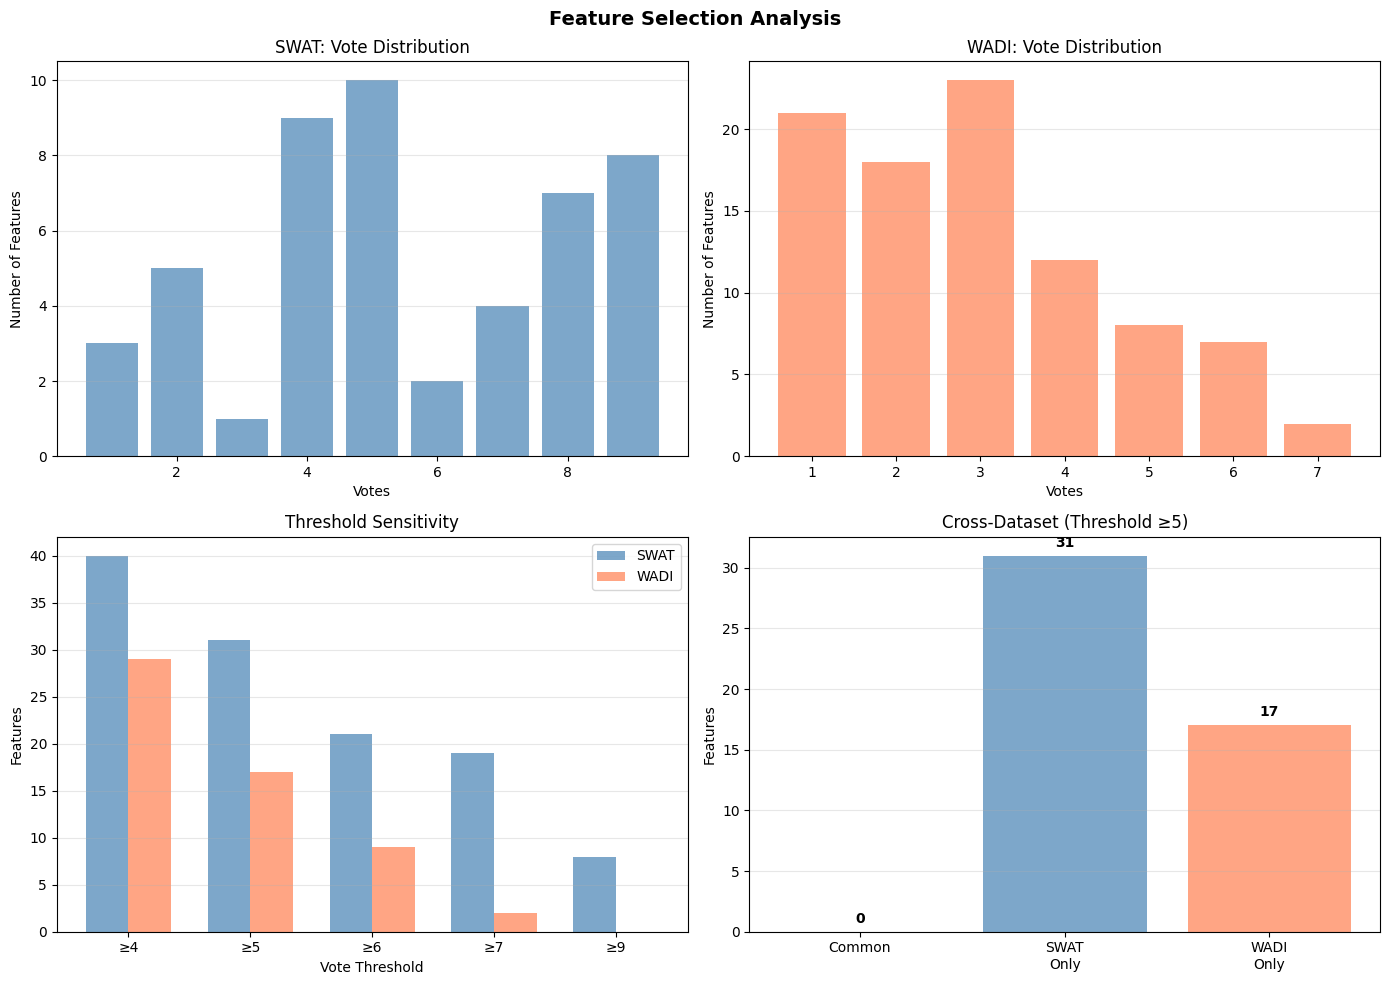

In [12]:
## STEP 12: Visualization

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Feature Selection Analysis', fontsize=14, fontweight='bold')

# SWAT vote distribution
swat_votes = results['SWAT']['voting_df']['Votes'].value_counts().sort_index(ascending=False)
axes[0, 0].bar(swat_votes.index, swat_votes.values, color='steelblue', alpha=0.7)
axes[0, 0].set_xlabel('Votes')
axes[0, 0].set_ylabel('Number of Features')
axes[0, 0].set_title('SWAT: Vote Distribution')
axes[0, 0].grid(axis='y', alpha=0.3)

# WADI vote distribution
wadi_votes = results['WADI']['voting_df']['Votes'].value_counts().sort_index(ascending=False)
axes[0, 1].bar(wadi_votes.index, wadi_votes.values, color='coral', alpha=0.7)
axes[0, 1].set_xlabel('Votes')
axes[0, 1].set_ylabel('Number of Features')
axes[0, 1].set_title('WADI: Vote Distribution')
axes[0, 1].grid(axis='y', alpha=0.3)

# Threshold sensitivity
thresholds = [4, 5, 6, 7, 9]
swat_counts = [len(results['SWAT']['threshold_results'].get(f'threshold_{t}', [])) for t in thresholds]
wadi_counts = [len(results['WADI']['threshold_results'].get(f'threshold_{t}', [])) for t in thresholds]

x = np.arange(len(thresholds))
width = 0.35
axes[1, 0].bar(x - width/2, swat_counts, width, label='SWAT', color='steelblue', alpha=0.7)
axes[1, 0].bar(x + width/2, wadi_counts, width, label='WADI', color='coral', alpha=0.7)
axes[1, 0].set_xlabel('Vote Threshold')
axes[1, 0].set_ylabel('Features')
axes[1, 0].set_title('Threshold Sensitivity')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([f'≥{t}' for t in thresholds])
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Cross-dataset comparison
comparison_data = {
    'Common': len(cross_validation['common_features']),
    'SWAT\nOnly': len(cross_validation['swat_only']),
    'WADI\nOnly': len(cross_validation['wadi_only'])
}
colors = ['green', 'steelblue', 'coral']
axes[1, 1].bar(comparison_data.keys(), comparison_data.values(), color=colors, alpha=0.7)
axes[1, 1].set_ylabel('Features')
axes[1, 1].set_title(f'Cross-Dataset (Threshold ≥{threshold})')
axes[1, 1].grid(axis='y', alpha=0.3)

for i, (k, v) in enumerate(comparison_data.items()):
    axes[1, 1].text(i, v + 0.5, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('v3_feature_selection_results.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved: v3_feature_selection_results.png")
plt.show()

## STEP 13: Save Results

In [13]:
import os
os.makedirs('results', exist_ok=True)

results['SWAT']['voting_df'].to_csv('results/SWAT_feature_voting.csv', index=False)
results['WADI']['voting_df'].to_csv('results/WADI_feature_voting.csv', index=False)

for threshold in [4, 5, 6, 7, 9]:
    swat_features = results['SWAT']['threshold_results'][f'threshold_{threshold}']
    wadi_features = results['WADI']['threshold_results'][f'threshold_{threshold}']
    pd.DataFrame({'Feature': swat_features}).to_csv(f'results/SWAT_threshold_{threshold}.csv', index=False)
    pd.DataFrame({'Feature': wadi_features}).to_csv(f'results/WADI_threshold_{threshold}.csv', index=False)

print("Results saved to 'results/' directory")

Results saved to 'results/' directory


## STEP 14: Final Summary

In [16]:
separator = "="*70
print(separator)
print("FINAL SUMMARY REPORT")
print(separator)

print("\nMETHODOLOGY:")
print("  - 9 Feature Selection Methods (Filter + Wrapper + Embedded)")
print("  - SMOTE balancing for imbalanced datasets")
print("  - Ensemble voting mechanism")
print("  - Model performance validation")
print("  - Threshold optimization")
print("  - Cross-dataset analysis")

print(f"\n{separator}")
print("SWAT DATASET RESULTS")
print(f"{separator}")

swat_log = results['SWAT']['reduction_log']
print(f"\nFeature Reduction:")
print(f"  Original features: {swat_log['original']}")
print(f"  After variance filter: {swat_log['after_variance']}")
print(f"  Unique in voting pool: {swat_log['unique_in_pool']}")
print(f"  Selected (threshold ≥5): {len(results['SWAT']['threshold_results']['threshold_5'])}")
print(f"  Top features (9/9 votes): {(results['SWAT']['voting_df']['Votes'] == 9).sum()}")

print(f"\nModel Performance (Random Forest):")
swat_rf = validation_results['SWAT'][validation_results['SWAT']['Model'] == 'Random Forest'].iloc[0]
print(f"  ALL features: {swat_rf['All_Features']:.0f}")
print(f"    F1-Score: {swat_rf['F1_All']:.4f}")
print(f"\n  SELECTED features: {swat_rf['Selected_Features']:.0f}")
print(f"    F1-Score: {swat_rf['F1_Selected']:.4f} ({swat_rf['F1_Diff']:+.4f})")
print(f"    Speedup:  {swat_rf['Speedup']:.2f}x faster")

swat_opt_idx = threshold_optimization['SWAT']['F1_Score'].idxmax()
swat_best_thresh = threshold_optimization['SWAT'].loc[swat_opt_idx, 'Threshold']
swat_best_f1 = threshold_optimization['SWAT'].loc[swat_opt_idx, 'F1_Score']
swat_best_nfeat = threshold_optimization['SWAT'].loc[swat_opt_idx, 'Num_Features']
print(f"\n  Optimal Threshold: {swat_best_thresh} ({swat_best_nfeat:.0f} features, F1={swat_best_f1:.4f})")

print(f"\n{separator}")
print("WADI DATASET RESULTS")
print(f"{separator}")

wadi_log = results['WADI']['reduction_log']
print(f"\nFeature Reduction:")
print(f"  Original features: {wadi_log['original']}")
print(f"  After variance filter: {wadi_log['after_variance']}")
print(f"  Unique in voting pool: {wadi_log['unique_in_pool']}")
print(f"  Selected (threshold ≥5): {len(results['WADI']['threshold_results']['threshold_5'])}")
print(f"  Top features (9/9 votes): {(results['WADI']['voting_df']['Votes'] == 9).sum()}")

print(f"\nModel Performance (Random Forest):")
wadi_rf = validation_results['WADI'][validation_results['WADI']['Model'] == 'Random Forest'].iloc[0]
print(f"  ALL features: {wadi_rf['All_Features']:.0f}")
print(f"    F1-Score: {wadi_rf['F1_All']:.4f}")
print(f"\n  SELECTED features: {wadi_rf['Selected_Features']:.0f}")
print(f"    F1-Score: {wadi_rf['F1_Selected']:.4f} ({wadi_rf['F1_Diff']:+.4f})")
print(f"    Speedup:  {wadi_rf['Speedup']:.2f}x faster")

wadi_opt_idx = threshold_optimization['WADI']['F1_Score'].idxmax()
wadi_best_thresh = threshold_optimization['WADI'].loc[wadi_opt_idx, 'Threshold']
wadi_best_f1 = threshold_optimization['WADI'].loc[wadi_opt_idx, 'F1_Score']
wadi_best_nfeat = threshold_optimization['WADI'].loc[wadi_opt_idx, 'Num_Features']
print(f"\n  Optimal Threshold: {wadi_best_thresh} ({wadi_best_nfeat:.0f} features, F1={wadi_best_f1:.4f})")

print(f"\n{separator}")
print("KEY INSIGHTS")
print(f"{separator}")

print("\nSTRENGTHS:")
print("  1. Feature reduction with minimal performance loss")
print(f"     - SWAT: {100*(1-swat_rf['Selected_Features']/swat_rf['All_Features']):.0f}% reduction, F1 change: {swat_rf['F1_Diff']:+.4f}")
print(f"     - WADI: {100*(1-wadi_rf['Selected_Features']/wadi_rf['All_Features']):.0f}% reduction, F1 change: {wadi_rf['F1_Diff']:+.4f}")
print("  2. Significant training speedup")
print(f"     - SWAT: {swat_rf['Speedup']:.1f}x faster")
print(f"     - WADI: {wadi_rf['Speedup']:.1f}x faster")
print("  3. Robust ensemble approach reduces method-specific bias")
print("  4. SMOTE balancing improves minority class discrimination")

print("\nRECOMMENDATIONS:")
print(f"  SWAT: Use threshold {swat_best_thresh} ({swat_best_nfeat:.0f} features)")
print(f"  WADI: Use threshold {wadi_best_thresh} ({wadi_best_nfeat:.0f} features)")

print("\nOUTPUT FILES:")
print("  Feature Selection:")
print("    - v3_swat_feature_voting.csv")
print("    - v3_wadi_feature_voting.csv")
print("    - v3_swat_threshold_5.csv")
print("    - v3_wadi_threshold_5.csv")
print("  Performance Validation:")
print("    - v3_swat_model_validation.csv")
print("    - v3_wadi_model_validation.csv")
print("    - v3_swat_threshold_optimization.csv")
print("    - v3_wadi_threshold_optimization.csv")
print("  Visualizations:")
print("    - v3_feature_selection_results.png")

print(f"\n{separator}")
print("FEATURE SELECTION COMPLETE")
print(f"{separator}")

FINAL SUMMARY REPORT

METHODOLOGY:
  - 9 Feature Selection Methods (Filter + Wrapper + Embedded)
  - SMOTE balancing for imbalanced datasets
  - Ensemble voting mechanism
  - Model performance validation
  - Threshold optimization
  - Cross-dataset analysis

SWAT DATASET RESULTS

Feature Reduction:
  Original features: 52
  After variance filter: 52
  Unique in voting pool: 49
  Selected (threshold ≥5): 31
  Top features (9/9 votes): 8

Model Performance (Random Forest):
  ALL features: 52
    F1-Score: 0.9696

  SELECTED features: 31
    F1-Score: 0.9732 (+0.0036)
    Speedup:  1.15x faster

  Optimal Threshold: ≥6 (21 features, F1=0.9733)

WADI DATASET RESULTS

Feature Reduction:
  Original features: 123
  After variance filter: 123
  Unique in voting pool: 91
  Selected (threshold ≥5): 17
  Top features (9/9 votes): 0

Model Performance (Random Forest):
  ALL features: 123
    F1-Score: 0.9474

  SELECTED features: 17
    F1-Score: 0.9507 (+0.0033)
    Speedup:  1.17x faster

  Opti